# Lecture 23: Linear Regression

In [ ]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline

## Review of correlation

In [ ]:
hybrid = Table.read_table('hybrid.csv')
hybrid.show(3)

In [ ]:
# Visualize: is there a linear relationship between two variables?
hybrid.scatter('acceleration', 'msrp', fit_line=True)

In [ ]:
def standard_units(numbers):
    "Convert any array of numbers to standard units."
    return (numbers - np.mean(numbers)) / np.std(numbers)  

def correlation(t, x, y):
    """Return the correlation coefficient (r) of two variables."""
    return np.mean(standard_units(t.column(x)) * standard_units(t.column(y)))
   
def standardize(t):
    "Covert table t to standard units."
    su = Table()
    for label in t.labels:
        su = su.with_column(label + ' (su)', standard_units(t.column(label)))
    return su

In [ ]:
# Quantify: how scattered are the points around a straight line?
correlation(hybrid, 'acceleration', 'msrp')

## Prediction using correlation

In [ ]:
galton = Table.read_table('galton.csv')
heights = galton.select('midparentHeight', 'childHeight')\
  .relabeled('midparentHeight', 'MidParent')\
  .relabeled('childHeight', 'Child')
heights.show(3)

In [ ]:
galton.show(3)

In [ ]:
heights.scatter('MidParent')

In [ ]:
heights_su = standardize(heights)
heights_su.scatter('MidParent (su)')

In [ ]:
def predict_child_su(new_midparent_height):
    close_points = heights_su.where('MidParent (su)', 
                                are.between(new_midparent_height - 0.5, 
                                            new_midparent_height + 0.5))
    return close_points.column('Child (su)').mean()    

heights_su_pred = heights_su.with_column(
    'Prediction (su)', heights_su.apply(predict_child_su, 'MidParent (su)')
)
heights_su_pred.scatter('MidParent (su)')

The yellow line is the *graph of averages*.

In [ ]:
r = correlation(heights, 'MidParent', 'Child')
r

## The graph of averages and $r$

In [ ]:
heights_su_pred.scatter('MidParent (su)')

# plot the line "y = r * x"
plots.plot([-3, 3.5], [-3*r, 3.5*r], color='blue', lw=2);

The line $y = r \times x$ is a version of the graph of averages, smoothed to a line.

## Prediction by linear regression

In [ ]:
parent_mean = np.mean(heights.column('MidParent'))
parent_sd = np.std(heights.column('MidParent'))
child_mean = np.mean(heights.column('Child'))
child_sd = np.std(heights.column('Child'))
print('Parent: mean =', parent_mean, '; SD =', parent_sd)
print(' Child: mean =', child_mean, '; SD =', child_sd)
print('     r:', r)

In [ ]:
def predict_with_r(parent):
    """Return a prediction of the height of a child whose parents 
    have a midparent height of mp, using linear regression.
    """
    parent_su = (parent - parent_mean) / parent_sd
    child_su = r * parent_su
    return child_su * child_sd + child_mean

In [ ]:
def predict_with_average(parent):
    """"Return a prediction of the height of a child whose parents 
    have a midparent height of mp, using the average of nearby parents.
    """
    close_points = heights.where('MidParent', 
                                are.between(parent - 0.5, 
                                            parent + 0.5))
    return close_points.column('Child').mean()  

In [ ]:
heights.with_columns(
    'Prediction with averages', heights.apply(predict_with_average, 'MidParent'),
    'Prediction with r', heights.apply(predict_with_r, 'MidParent')
).scatter('MidParent')

## Slope and Intercept

In [ ]:
def slope(t, x, y):
    """The slope of the regression line (original units)."""
    r = correlation(t, x, y)
    return r * np.std(t.column(y)) / np.std(t.column(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)."""
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))

In [ ]:
predict_with_r(74)

In [ ]:
def predict_with_slope_and_intercept(x):
    s = slope(heights, 'MidParent', 'Child')
    i = intercept(heights, 'MidParent', 'Child')
    return s * x + i

In [ ]:
predict_with_slope_and_intercept(74)

In [ ]:
# From an actual class, but anonymized
exams = Table().read_table('exams.csv')
exams.show(3)

In [ ]:
# Does linear regression look appropriate?
exams.scatter('prelim', fit_line=True)
plots.xlim(35, 105);
plots.ylim(35, 105);

In [ ]:
r = correlation(exams, 'prelim', 'final')
s = slope(exams, 'prelim', 'final')
i = intercept(exams, 'prelim', 'final')
print('Correlation: ', r)
print('Slope:       ', s)
print('Intercept:   ', i)

**Q:** Which equation would you use to predict a final exam score $y$ given a prelim score $x$, both in original units (percent)?

A. $y = r \times x$  
B. $y = r \times x + i$  
C. $y = s \times x + i$  
D. none of the above


In [ ]:
def predict_final(prelim):
    return s * prelim + i

In [ ]:
predict_final(100) # regression to the mean?

In [ ]:
predict_final(30)

In [ ]:
exams.scatter('prelim')
plots.xlim(35, 105);
plots.ylim(35, 105);

# plot the regression line
x = make_array(40, 100)
y = s * x + i
plots.plot(x, y);

## Abuses of $r$

**1. Summarizing non-linear data**

In [ ]:
new_x = np.arange(-4, 4.1, 0.5)
nonlinear = Table().with_columns(
        'x', new_x,
        'y', new_x**2
    )
nonlinear.scatter('x', 'y', s=30, color='r')

In [ ]:
correlation(nonlinear, 'x', 'y')

There is definitely a relationship between $x$ and $y$.  It's just not linear.

**2. Eliminating outliers to "improve" $r$**

In [ ]:
line = Table().with_columns(
        'x', [1, 2, 3, 4],
        'y', [1, 2, 3, 4]
    )
line.scatter('x', 'y', s=30, color='r')

In [ ]:
correlation(line, 'x', 'y')

In [ ]:
outlier = Table().with_columns(
        'x', [1, 2, 3, 4, 5],
        'y', [1, 2, 3, 4, 0]
    )
outlier.scatter('x', 'y', s=30, color='r')

In [ ]:
correlation(outlier, 'x', 'y')

Because weight that outlier contributes to product is huge and offsets the linearity of the rest of the data.  **Do not rush to eliminate outliers from data.**  Maybe that data point is a measurement error, but maybe it indicates underlying population is non-linear.

**3. Drawing conclusions about individuals based on data about groups**

In [ ]:
# Participation rate = % of high school seniors who took SAT
# Scores are average scores across state
sat2014 = Table.read_table('sat2014.csv')
sat2014.sort('Combined', descending=True)
#sat2014.sort('Participation Rate',descending=True)

In [ ]:
sat2014.scatter('Participation Rate', 'Combined')
correlation(sat2014, 'Participation Rate', 'Combined')

**Q:** States with higher participation rates have lower average scores.  Why?

In [ ]:
sat2014.scatter('Critical Reading', 'Math')

In [ ]:
correlation(sat2014, 'Critical Reading', 'Math')

**Q:** Do students with high reading scores also have high math scores?

A. Yes  
B. No  
C. Maybe


## Quantifying error

In [58]:
def read_file(f):
    with open (f, 'r') as file:
        data=file.read()
    return data
lw_text = read_file('little_women.txt')
lw_chapters = lw_text.split('CHAPTER ')[1:]
lw = Table().with_columns(
    'Periods', np.char.count(lw_chapters, '.'),
    'Characters', np.vectorize(len)(lw_chapters),
)

lw.show(3)

Periods,Characters
189,21952
188,22384
231,20815


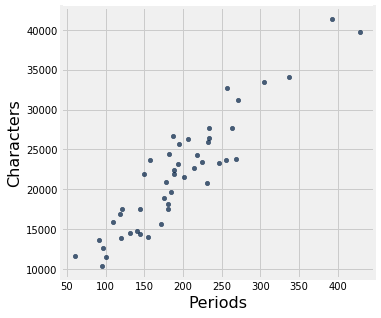

In [59]:
lw.scatter('Periods', 'Characters')

In [60]:
correlation(lw, 'Periods', 'Characters')

0.9249621978954679

In [ ]:
def linear_predict(t, x, y):
    """Return the height of the regression line at each x value."""
    s = slope(t, x, y)
    i = intercept(t, x, y)
    return s * t.column(x) + i

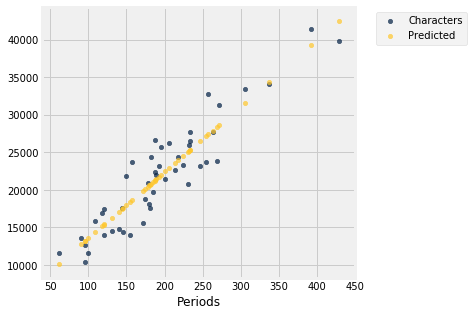

In [61]:
lw_predicted = lw.with_column(
    'Predicted', linear_predict(lw, 'Periods', 'Characters')
)
lw_predicted.scatter('Periods')

In [62]:
sample = [[131, 14431], [231, 20558], [392, 40935], [157, 23524]]
def lw_errors(slope, intercept):
    print('Slope:    ', np.round(slope), 'characters per period')
    print('Intercept:', np.round(intercept), 'characters')
    lw.scatter('Periods', 'Characters')
    xlims = np.array([50, 450])
    plots.plot(xlims, slope * xlims + intercept, lw=2)
    for x, y in sample:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=2)

Slope:     88.0 characters per period
Intercept: 4802.0 characters


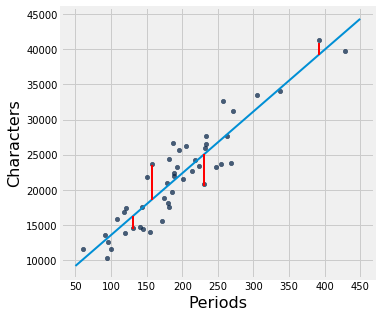

In [63]:
lw_reg_slope = slope(lw, 'Periods', 'Characters')
lw_reg_intercept = intercept(lw, 'Periods', 'Characters')
lw_errors(lw_reg_slope, lw_reg_intercept)

In [64]:
error = lw_predicted.column('Characters') - lw_predicted.column('Predicted')
lw_predicted_error = lw_predicted.with_column(
    'Error', error
)
lw_predicted_error.show(3)

Periods,Characters,Predicted,Error
189,21952,21403.2,548.802
188,22384,21315.4,1068.64
231,20815,25092.4,-4277.38


**Q:** What would be a good way to summarize all those errors as a single number?

## RMSE

In [65]:
lw_predicted_error_sq = lw_predicted_error.with_column(
    'Squared Error', error ** 2
)
lw_predicted_error_sq.show(3)

Periods,Characters,Predicted,Error,Squared Error
189,21952,21403.2,548.802,301183
188,22384,21315.4,1068.64,1.14199e+06
231,20815,25092.4,-4277.38,1.8296e+07


In [66]:
mean_squared_error = np.mean(lw_predicted_error_sq.column('Squared Error'))
mean_squared_error

7226605.108665576

In [67]:
root_mean_squared_error = np.sqrt(mean_squared_error)
root_mean_squared_error

2688.2345709899605

rmse = SD($y$) $\times \sqrt{1 - r^2}$

In [68]:
np.sqrt(1 - correlation(lw, 'Periods', 'Characters')**2) * np.std(lw.column('Characters'))

2688.2345709899623

## Comparing lines with RMSE

In [72]:
def lw_visualize_rmse(slope, intercept):
    lw_errors(slope, intercept)
    x = lw.column('Periods')
    y = lw.column('Characters')
    predicted = slope * x + intercept
    mse = np.mean((y - predicted) ** 2)
    print("RMSE:     ", mse ** 0.5)

Slope:     50 characters per period
Intercept: 10000 characters
RMSE:      4459.945911321672


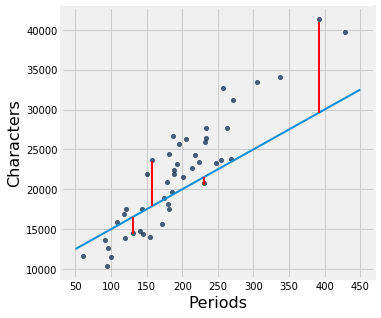

In [73]:
lw_visualize_rmse(50, 10000)

**Q:** Which way should I adjust slope to reduce error?

A. Up  
B. Down  
C. I'm not sure  

Slope:     88.0 characters per period
Intercept: 4802.0 characters
RMSE:      2688.2345709899605


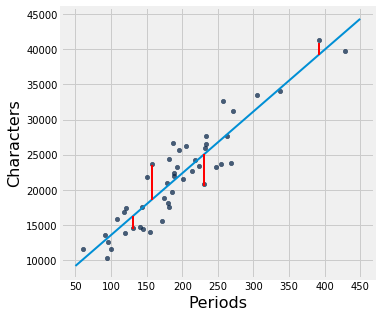

In [74]:
lw_reg_slope = slope(lw, 'Periods', 'Characters')
lw_reg_intercept = intercept(lw, 'Periods', 'Characters')
lw_visualize_rmse(lw_reg_slope, lw_reg_intercept)

## Finding the line with least RMSE

In [76]:
def f(x):
    return (x - 3) ** 2 + 1

**Q:** What value of `x` will produce the smallest value of `f(x)`?

A. 0  
B. 1  
C. 2  
D. 3  
E. none of the above

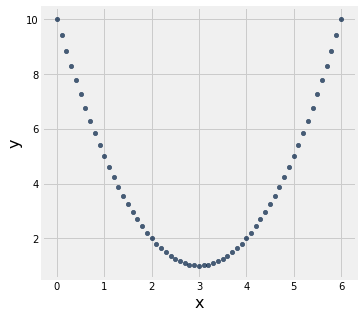

In [77]:
x = np.arange(0, 6.1, .1)
y = f(x)
Table().with_columns('x', x, 'y', y).scatter('x')

In [78]:
minimize(f)

2.999999999968361

In [79]:
f(minimize(f))

1.0

In [81]:
def lw_rmse(any_slope, any_intercept):
    """Compute the RMSE for a line through the Little Women data.
    The line has the slope and intercept given as arguments."""
    x = lw.column('Periods')
    y = lw.column('Characters')
    predicted = any_slope*x + any_intercept
    return np.sqrt(np.mean((y - predicted) ** 2))

In [82]:
lw_rmse(50, 10000)

4459.945911321672

In [83]:
best = minimize(lw_rmse)
best

array([  87.83764729, 4801.88299808])

In [84]:
lw_rmse(best.item(0), best.item(1))

2688.23457098996

In [85]:
make_array(lw_reg_slope, lw_reg_intercept)

array([  87.83764729, 4801.88300867])

In [86]:
lw_rmse(lw_reg_slope, lw_reg_intercept)

2688.2345709899605